<a href="https://colab.research.google.com/github/Baba-777/Repos1/blob/master/Project_1_Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1 — or 1. [Data Collection] Setup & quick data inspection
Load the  libraries, read the file, inspect shape & columns and basic missing-value information.

In [11]:
import pandas as pd
import numpy as np

DATA_PATH = "/content/AB_NYC_2019.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nSample rows:")
display(df.head())
print("\nMissing values (top columns):")
print(df.isnull().sum().sort_values(ascending=False).head(15))


Shape: (48895, 16)

Columns:
 ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Sample rows:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0



Missing values (top columns):
last_review                       10052
reviews_per_month                 10052
host_name                            21
name                                 16
neighbourhood_group                   0
neighbourhood                         0
id                                    0
host_id                               0
longitude                             0
latitude                              0
room_type                             0
price                                 0
number_of_reviews                     0
minimum_nights                        0
calculated_host_listings_count        0
dtype: int64


Step 2 —  or [ Data Exploration & Data Preprocessing] Clean data & basic EDA (remove bad rows / outliers)

Remove the  duplicates, convert date fields, remove zero/negative prices and extreme outliers and  also show the  few EDA charts.

After cleaning shape: (14602, 16)
Price stats:
count    14602.000000
mean       135.355705
std         84.443755
min         10.000000
25%         75.000000
50%        115.000000
75%        175.000000
max        500.000000
Name: price, dtype: float64


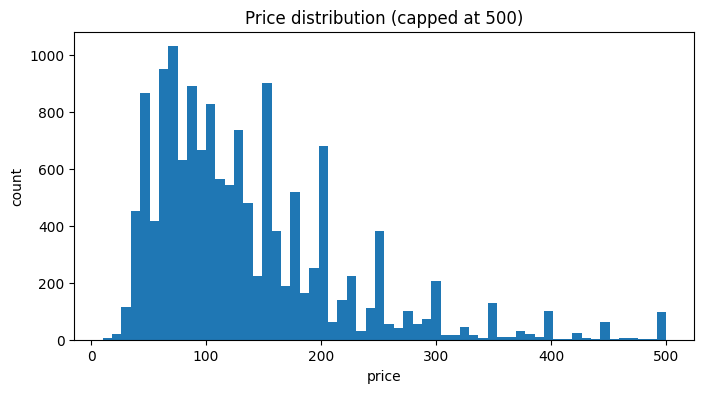


Average price by neighbourhood_group:
 neighbourhood_group
Manhattan        157.799175
Brooklyn         120.467847
Staten Island    107.257576
Queens            95.825355
Bronx             80.540984
Name: price, dtype: float64


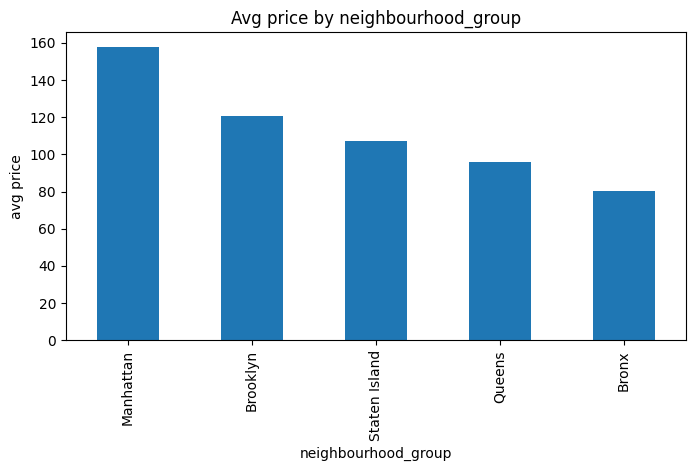

In [2]:
# Step 2: Data cleaning & simple EDA
import matplotlib.pyplot as plt

# Basic cleaning
df = df.copy()
df.drop_duplicates(inplace=True)

# Converted the  date columns
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Removd the invalid prices and extreme outliers
df = df[df['price'] > 0]          # drop zero or negative prices
df = df[df['price'] <= 500]       # cap to 500

print("After cleaning shape:", df.shape)
print("Price stats:")
print(df['price'].describe())

# Quick EDA plots shown below
plt.figure(figsize=(8,4))
plt.hist(df['price'], bins=60)
plt.title('Price distribution (capped at 500)')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

# Avg price by neighbourhood_group
avg_by_group = df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
print("\nAverage price by neighbourhood_group:\n", avg_by_group)
avg_by_group.plot(kind='bar', figsize=(8,4), title='Avg price by neighbourhood_group')
plt.ylabel('avg price')
plt.show()


Step 3 —  or [ Data Preprocessing ] Feature engineering & preprocessing pipeline

Create the  features and build a sklearn preprocessing pipeline (imputation + one-hot encoding for categoricals, passthrough numerics).I used the  a small set of features that work well for price prediction.

In [5]:
# Step 3: Feature engineering & preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select features
features = [
    'neighbourhood_group', 'neighbourhood', 'room_type',
    'latitude', 'longitude', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
]

df_model = df.dropna(axis=0, subset=['price']).copy()
X = df_model[features]
y = df_model['price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Feature groups
numeric_features = [
    'latitude', 'longitude', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
]

categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Updated Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Final preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Step 4 — Train models (Linear Regression and XGBoost) + evaluate

Train a baseline Linear Regression and a stronger XGBoost model. Installed the  xgboost.

In [13]:
# Step 4: Train models and evaluate

!pip install xgboost -q

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
import numpy as np

# Linear Regression pipeline
lr_pipeline = make_pipeline(preprocessor, LinearRegression())
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# XGBoost pipeline
xgb_pipeline = make_pipeline(
    preprocessor,
    XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )
)
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

# ---------- FIXED EVALUATION FUNCTION ----------
def eval_preds(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)     # no squared=False allowed
    rmse = np.sqrt(mse)                          # compute RMSE manually
    mae = mean_ab_






Step -5 or [ Conclusion]  Save model, save predictions, and extract feature importance

In [10]:
# STEP 5: Save model, save predictions, and extract feature importance
import joblib
import pandas as pd
import numpy as np

# ---------- SAVE MODEL ----------
joblib.dump(xgb_pipeline, "airbnb_xgb_model.pkl")
print("Model saved as: airbnb_xgb_model.pkl")

# ---------- SAVE PREDICTIONS ----------
pred_df = pd.DataFrame({
    "actual_price": y_test.values,
    "predicted_price": y_pred_xgb
})
pred_df.to_csv("airbnb_price_predictions.csv", index=False)
print("Predictions saved as: airbnb_price_predictions.csv")

# ---------- FEATURE IMPORTANCE (WORKING VERSION) ----------
# To extract feature names after ColumnTransformer + OneHotEncoder
# We must manually transform X_train

# 1. Fit the preprocessor alone
preprocessor.fit(X_train)

# 2. Transform data
X_train_transformed = preprocessor.transform(X_train)

# 3. Extract feature names
num_features = numeric_features
cat_features = list(
    preprocessor.named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

all_features = num_features + cat_features

# 4. Get feature importances from the XGBoost model
xgb_model = xgb_pipeline.named_steps['xgbregressor']
importances = xgb_model.feature_importances_

# 5. Convert to a sorted dataframe
fi = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop 15 Important Features:")
display(fi.head(15))

fi.to_csv("feature_importance.csv", index=False)
print("Feature importance saved as: feature_importance.csv")




Model saved as: airbnb_xgb_model.pkl
Predictions saved as: airbnb_price_predictions.csv

Top 15 Important Features:


,feature,importance
193,room_type_Entire home/apt,0.301233
9,neighbourhood_group_Manhattan,0.049696
189,neighbourhood_Williamsburg,0.018918
1,longitude,0.018745
178,neighbourhood_Upper East Side,0.016102
117,neighbourhood_Midtown,0.015712
6,availability_365,0.013891
175,neighbourhood_Tribeca,0.012811
131,neighbourhood_NoHo,0.012372
154,neighbourhood_Sheepshead Bay,0.012268


Feature importance saved as: feature_importance.csv
